# DSCI 550 Assignment 1


Katie Chak: chakw@usc.edu

## Load updated json file

In [2]:
import json 
f = open("fraudulent_emails_update.json",) 
messages = json.load(f) 

###  Stylometrics

### viii. Attacker language style

2. Random capitalization (test different thresholds)

Check capitalization and period ratio

In [3]:
import pandas as pd
import numpy as np

In [8]:
def read_file(filename):
    with open(filename, 'r') as file:
        data = file.read().replace('\n', '')
    return data

In [9]:
str1=read_file("opinion_1.txt")
str2=read_file("academic_journal_2.txt")
str3=read_file("opinion_2.txt")
str4=read_file("opinion_4.txt")
str5=read_file("opinion_3.txt")
str6=read_file("academic_journal_3.txt")
str7=read_file("diary_4.txt")
str8=read_file("poem_1.txt")
str9=read_file("poem_2.txt")
str10=read_file("poem_3.txt")
str11=read_file("poem_4.txt")

In [34]:
# counts number of capital letters and periods in a string and returns the ratio

def count_period_ratio(string):
    """Input is a string of article"""
    period_cnt=0
    capital_cnt=0
    
    for letter in string:
        if letter==".":
            period_cnt+=1
        elif letter.isupper()==True:
            capital_cnt+=1
    
    ratio=capital_cnt/period_cnt
    return ratio
        

In [18]:
strlist=[str1,str2,str3,str4,str5,str6,str7,str8,str9,str10,str11]

Make a list of ratios from some test strs (articles, academic journals, poems, and diaries)

In [19]:
ratearray=[]
for strs in strlist:
    ratearray.append(count_period_ratio(strs))

In [20]:
df1=pd.DataFrame(ratearray).describe()
df1.columns=["normal_text"]
df1

normal_text
count    11.000000
mean      3.472511
std       1.381239
min       1.903771
25%       2.571014
50%       3.127660
75%       3.761157
max       6.666667

In [9]:
testarray=[]
for i in range (1000):
    try:
        testarray.append(count_period_ratio(messages[i]["X-TIKA:content"].strip().lstrip()))
    except ZeroDivisionError:
        pass
    continue

Take a sample scam email texts to compare thresholds

In [12]:
df2=pd.DataFrame(testarray).describe()
df2.columns=["999_scam_text"]
df2

999_scam_text
count     999.000000
mean       18.358437
std        31.228246
min         0.000000
25%         3.803226
50%         5.448276
75%         9.871711
max       226.142857

In [21]:
df3=pd.concat([df1,df2],axis=1)
df3

normal_text  999_scam_text
count    11.000000     999.000000
mean      3.472511      18.358437
std       1.381239      31.228246
min       1.903771       0.000000
25%       2.571014       3.803226
50%       3.127660       5.448276
75%       3.761157       9.871711
max       6.666667     226.142857

The threshold for irregular capitalization should be >1 (given that one capitalized word would be followed by a period) and <3.76 (75 percentile for regular text)

In [35]:
for message in messages:
    try:
        message["capitalization_ratio"]=count_period_ratio(message["X-TIKA:content"].strip().lstrip())
    except ZeroDivisionError:
        message["capitalization_ratio"]=0
    continue
    


In [23]:
import matplotlib.pyplot as plt

In [24]:
cap=[]
for message in messages:
    cap.append(message["capitalization_ratio"])
cap_df=pd.DataFrame(cap)

In [25]:
cap_df.describe()

0
count  3978.000000
mean     13.735450
std      25.535405
min       0.000000
25%       3.500000
50%       4.931034
75%       7.893275
max     226.142857

### Visualization of capitalization ratio distribution

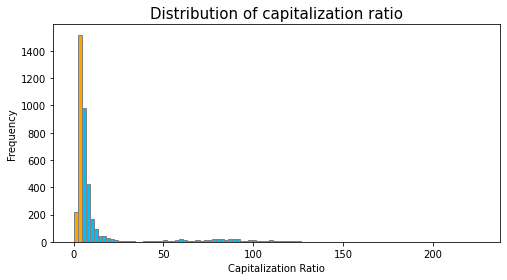

In [26]:
fig, ax = plt.subplots(figsize=(8,4,))
counts, bins, patches = ax.hist(cap_df, facecolor="orange", edgecolor='gray',bins=100)
#ax.set_xticks(bins.round(2))
#plt.xticks(rotation=70)
plt.title('Distribution of capitalization ratio', fontsize=15)
plt.ylabel('Frequency', fontsize=10)
plt.xlabel('Capitalization Ratio', fontsize=10)

for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
    if rightside < 1:
        patch.set_facecolor("peachpuff")
    elif leftside > 3.76:
        patch.set_facecolor("deepskyblue")

In [131]:
msg_len=[]
for message in messages:
    msg_len.append(len(message["X-TIKA:content"].strip().lstrip().split(" ")))

In [138]:
norm_df=pd.concat([cap_df,pd.DataFrame(msg_len)],axis=1)
norm_df.columns=["cap_ratio","msg_size"]

## Normalized data based on email size

In [162]:
norm_df["norm_ratio"]=norm_df["cap_ratio"]/norm_df["msg_size"]

In [175]:
norm_df.describe()

cap_ratio      msg_size   norm_ratio
count  3978.000000   3978.000000  3978.000000
mean     13.735450    433.031674     0.041714
std      25.535405    409.480770     0.130544
min       0.000000      2.000000     0.000000
25%       3.500000    312.000000     0.008202
50%       4.931034    420.000000     0.012699
75%       7.893275    523.000000     0.023271
max     226.142857  22867.000000     6.000000

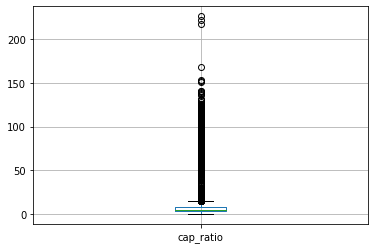

In [184]:
boxplot = norm_df.boxplot(column=["cap_ratio"])

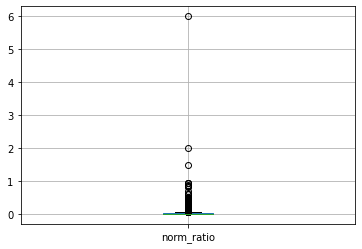

In [181]:
boxplot = norm_df.boxplot(column=["norm_ratio"])

In [ ]:
#import sys
#!{sys.executable} -m pip install symspellpy

In [4]:
import pkg_resources
from symspellpy import SymSpell, Verbosity
import re

# Initialize symspell object
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# !!! Account for other languages? I.e. French and Spanish messages
# Find and load the dictonary resources
dictionary_path = pkg_resources.resource_filename('symspellpy', 'frequency_dictionary_en_82_765.txt')
bigram_path = pkg_resources.resource_filename('symspellpy', 'frequency_bigramdictionary_en_243_342.txt')
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# Compile regex patterns to ignore in message body contents
whitespace_ptrn = re.compile(r'\s')
punctuation_ptrn = re.compile(r'[^\w\s\-]')
number_ptrn = re.compile(r'[0-9]')
letter_ptrn = re.compile(r'[a-z]')

# List of stopwords
stopwords = set(['mr', 'dr', 'mrs', 'usd', 'usdm', 'phd', 'hrm', 'ceo', 'drc', 'jk', 'mb', 'kg', 'nnpc', 'es', 'ie', 'ps', 'kabila'])

# Iterate over messages and find incorrect spellings
for message in messages:
    # Add author name to stopwords
    if 'Author' in message:
        if type(message['Author']) == list:
            author = message['Author'][-1]
        elif type(message['Author']) == str:
            author = message['Author']
        author = whitespace_ptrn.sub(' ', author)
        author = punctuation_ptrn.sub('', author).replace('_','')
        for part in author.split(' '):
            if part != '':
                stopwords.add(part.lower())
    # Count all words
    words = 0
    # Count misspellings
    misspellings = 0
    # Normalize and split message content
    content = whitespace_ptrn.sub(' ', message['X-TIKA:content'])
    content = punctuation_ptrn.sub('', content).replace('_','')
    content = number_ptrn.sub('', content)
    content = content.lower().split(' ')
    # Iterate over split content
    for word in content:
        # Ignore empty strings and words that do not have any letters (i.e. "--")
        if word and letter_ptrn.search(word):
            # Record word
            words += 1
            # Don't check spellings of stopwords or words with length <= 1
            if word not in stopwords and len(word)>1:
                suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
                # Record misspelled words
                if len(suggestions) > 1:
                    misspellings +=1
    # Save ratio of misspellings
    message['misspelled_ratio'] = misspellings/words



### Overview of misspelling distribution

In [75]:
misspells=[]
for message in messages:
    misspells.append(message["misspelled_ratio"])
mp_df=pd.DataFrame(misspells)
mp_df.describe()

0
count  3978.000000
mean      0.021802
std       0.047104
min       0.000000
25%       0.008201
50%       0.014381
75%       0.023034
max       0.522152

In [186]:
mnorm_df=pd.concat([mp_df,pd.DataFrame(msg_len)],axis=1)
mnorm_df.columns=["misspell_ratio","msg_size"]

In [189]:
mnorm_df["norm_ratio"]=mnorm_df["misspell_ratio"]/mnorm_df["msg_size"]

In [191]:
mnorm_df.describe()

misspell_ratio      msg_size   norm_ratio
count     3978.000000   3978.000000  3978.000000
mean         0.021802    433.031674     0.000081
std          0.047104    409.480770     0.000481
min          0.000000      2.000000     0.000000
25%          0.008201    312.000000     0.000018
50%          0.014381    420.000000     0.000033
75%          0.023034    523.000000     0.000060
max          0.522152  22867.000000     0.021978

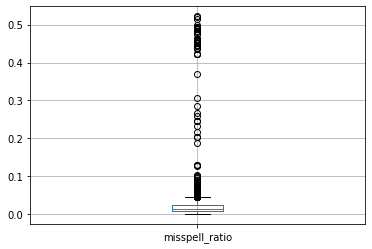

In [193]:
boxplot = mnorm_df.boxplot(column=["misspell_ratio"])

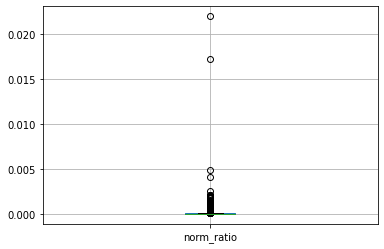

In [194]:
boxplot = mnorm_df.boxplot(column=["norm_ratio"])

### Most misspelling lies between 0 and 0.1

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

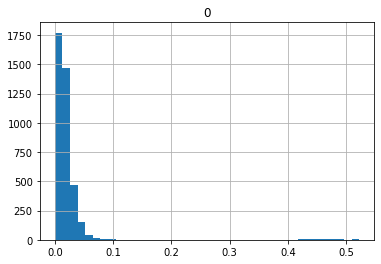

In [78]:
mp_df.hist(bins=40)

# Topic Modeling

In [4]:
# tokenize each word
import spacy
spacy.load("en_core_web_sm")
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [5]:
# lemmatize each word
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wingyan01pd2016/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# filter stop words
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wingyan01pd2016/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

convert each messgae into clean tokens 

Tokenization is the process of chopping up big chunks of text (emails) and filter out unhelpful content (punctuations, stop words) and in the process lemmatizes each words so they can be grouped together for analysis

In [8]:
import random
text_data = []
for message in messages:
    
    tokens = prepare_text_for_lda(message["X-TIKA:content"].strip().lstrip())
    if random.random() > .99:
        #print(tokens)
        text_data.append(tokens)

In [10]:
len(text_data)

40

convert to bag-of-words corpus and save the dictionary and corpus for future use

In [15]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

/Users/wingyan01pd2016/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [16]:
import gensim
NUM_TOPICS = 13
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model13.gensim')
topics = ldamodel.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.014*"trust" + 0.014*"contact" + 0.010*"mutual" + 0.010*"savimbi" + 0.007*"account" + 0.007*"father"')
(1, '0.017*"funds" + 0.010*"lawyer" + 0.010*"khodorkovsky" + 0.010*"mikhail" + 0.007*"company" + 0.007*"bless"')
(2, '0.012*"research" + 0.012*"payment" + 0.011*"address" + 0.011*"branch" + 0.007*"money" + 0.007*"transfer"')
(3, '0.024*"husband" + 0.013*"deposit" + 0.011*"president" + 0.011*"company" + 0.009*"funds" + 0.009*"security"')
(4, '0.017*"father" + 0.013*"business" + 0.011*"money" + 0.011*"death" + 0.010*"regard" + 0.009*"assistance"')
(5, '0.024*"money" + 0.021*"company" + 0.014*"contact" + 0.012*"deposit" + 0.009*"security" + 0.009*"country"')
(6, '0.020*"account" + 0.011*"transaction" + 0.010*"transfer" + 0.009*"contact" + 0.008*"funds" + 0.008*"deposit"')
(7, '0.015*"contract" + 0.015*"south" + 0.015*"committee" + 0.014*"world" + 0.013*"transfer" + 0.012*"member"')
(8, '0.025*"payment" + 0.018*"money" + 0.013*"receive" + 0.013*"courier" + 0.010*"security" + 0.008*"

# Attacker Relationship

In [43]:
relationship={"foreign_partner":["foreign","partner","father","majesty","assistance","sister"],
             "stranger_in_need":["wife","husband","son","father","sister"],
              "friend":["friend","dear","help","assistance","money"]
             
             }

In [44]:
for message in messages:
    # initializing topic ratios
    t1=0
    t2=0
    t3=0

    words=0
    for k,v in relationship.items():
        #print(k,v)
        email=message["X-TIKA:content"].lstrip().strip()
        token=prepare_text_for_lda(email)
        #print(token)
        for word in token:
            if word in v and k=="foreign_partner":
                t1+=1
            if word in v and k=="stranger_in_need":
                t2+=1
            if word in v and k=="friend":
                t3+=1
        
            words+=1
    t1=t1/words
    t2=t2/words
    t3=t3/words

    total_list=[t1,t2,t3]
    #print(total_list)
    #print(total_list)
    #sort list in ascending order
    total_list.sort()
    if total_list[-1]==t1:
        message["relationship"]="foreign_partner"
    elif total_list[-1]==t2:
        message["relationship"]="stranger_in_need"
    else:
        message["relationship"]="friend"
    print(message["relationship"])
    

    

friend
friend
foreign_partner
foreign_partner
friend
foreign_partner
friend
foreign_partner
friend
friend
foreign_partner
friend
friend
foreign_partner
friend
stranger_in_need
foreign_partner
foreign_partner
friend
friend
foreign_partner
foreign_partner
friend
foreign_partner
friend
friend
foreign_partner
foreign_partner
friend
foreign_partner
stranger_in_need
friend
foreign_partner
foreign_partner
foreign_partner
foreign_partner
friend
foreign_partner
foreign_partner
foreign_partner
foreign_partner
friend
friend
foreign_partner
foreign_partner
stranger_in_need
foreign_partner
foreign_partner
foreign_partner
foreign_partner
foreign_partner
friend
foreign_partner
friend
friend
friend
foreign_partner
friend
friend
foreign_partner
foreign_partner
foreign_partner
foreign_partner
stranger_in_need
friend
foreign_partner
friend
friend
foreign_partner
foreign_partner
foreign_partner
foreign_partner
friend
friend
stranger_in_need
friend
foreign_partner
foreign_partner
friend
foreign_partner
for

In [44]:
# pip install pyLDAvis

In [37]:
import pyLDAvis.gensim

In [38]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model13.gensim')

lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)



# Attacker offering

Topic 1: asks for money for family emergency {t1:["relative","deceased","money",]}

Topic 2: asks for money for charity {t2:["charity","friend","bless"]}

Topic 3: asks to transfer money to Africa for foreign assistance {t3:["Africa","funds","contract","foreign"]}

Topic 4: asks for money for business investment funds {t4:["business","investment","transaction","document"]}

Topic 5: job offer from Tasaki-Shinju {t5:["tasaki","shinju","company","family","job"]}

Topic 6: offering sum of money from bank in Nigeria {t6:["foreign","fund","nigeria","country"]}

Topic 7: need help to get sums of money (will split sum) {t7:["split", "unclaimed","transfer","claim","father"]}

In [45]:
offerings={"t1":["relative","deceased","money","family"],"t2":["charity","friend","bless","cheque","organization","ramitez"],"t3":["Africa","funds","contract","foreign"],"t4":["business","investment","transaction","document"],"t5":["tasaki","shinju","company","family","job"],"t6":["foreign","fund","nigeria","country"],"t7":["split", "unclaimed","transfer","claim","father"]}

Add offering to messages:

In [36]:
offerings

{'t1': ['relative', 'deceased', 'money', 'family'],
 't2': ['charity', 'friend', 'bless', 'cheque', 'organization', 'ramitez'],
 't3': ['Africa', 'funds', 'contract', 'foreign'],
 't4': ['business', 'investment', 'transaction', 'document'],
 't5': ['tasaki', 'shinju', 'company', 'family', 'job'],
 't6': ['foreign', 'fund', 'nigeria', 'country'],
 't7': ['split', 'unclaimed', 'transfer', 'claim', 'father']}

In [26]:
def get_ans(topic_wrd_cnt,total_word,topic_name):
    ratio=topic_wrd_cnt/total_word
    # returns tuple of topic name and its strength
    return (ratio,topic_name)

In [30]:
for message in messages:
    # initializing topic ratios
    t1=0
    t2=0
    t3=0
    t4=0
    t5=0
    t6=0
    t7=0
    words=0
    for k,v in offerings.items():
        #print(k,v)
        email=message["X-TIKA:content"].lstrip().strip()
        token=prepare_text_for_lda(email)
        #print(token)
        for word in token:
            if word in v and k=="t1":
                t1+=1
            if word in v and k=="t2":
                t2+=1
            if word in v and k=="t3":
                t3+=1
            if word in v and k=="t4":
                t4+=1
            if word in v and k=="t5":
                t5+=1
            if word in v and k=="t6":
                t6+=1
            if word in v and k=="t7":
                t7+=1
            words+=1
    t1=get_ans(t1,words,"t1")
    t2=get_ans(t2,words,"t2")
    t3=get_ans(t3,words,"t3")
    t4=get_ans(t4,words,"t4")
    t5=get_ans(t5,words,"t5")
    t6=get_ans(t6,words,"t6")
    t7=get_ans(t7,words,"t7")
    total_list=[t1,t2,t3,t4,t5,t6,t7]
    #print(total_list)
    #print(total_list)
    #sort list in ascending order
    total_list.sort()
    
    message["offering"]=total_list[-1]
    #print(message["offering"])
    

    

(0.004366812227074236, 't6')
(0.009481668773704172, 't6')
(0.007482993197278911, 't1')
(0.007482993197278911, 't1')
(0.004186289900575615, 't5')
(0.008605851979345954, 't3')
(0.007575757575757576, 't1')
(0.0076077768385460695, 't7')
(0.005521048999309869, 't6')
(0.007575757575757576, 't1')
(0.004005340453938585, 't6')
(0.008681925808997633, 't4')
(0.007462686567164179, 't4')
(0.004591836734693878, 't6')
(0.005194805194805195, 't6')
(0.003536067892503536, 't6')
(0.006015037593984963, 't6')
(0.006015037593984963, 't6')
(0.003940886699507389, 't4')
(0.003940886699507389, 't4')
(0.004578754578754579, 't6')
(0.006802721088435374, 't7')
(0.008465608465608466, 't4')
(0.005447941888619854, 't4')
(0.008465608465608466, 't4')
(0.008465608465608466, 't4')
(0.00695322376738306, 't3')
(0.00695322376738306, 't3')
(0.008771929824561403, 't1')
(0.004591836734693878, 't6')
(0.003341687552213868, 't4')
(0.008984725965858042, 't1')
(0.006711409395973154, 't6')
(0.009774436090225564, 't3')
(0.006802721088

In [42]:
for message in messages:
    if "friend" in message["X-TIKA:content"]:
        print(message["X-TIKA:content"].lstrip().strip())

I Need Your Assistance.

Dear sir, 
 
It is with a heart full of hope that I write to seek your help in respect of the context below. I am Mrs. Maryam Abacha the former first lady of the former Military Head of State of Nigeria General Sani Abacha whose sudden death occurred on 8th of June 1998 as a result of cardiac arrest (heart attack) while on the seat of power. 
I have no doubt about your capability and good-will to assist me in receiving into your custody (for safety) the sum of US$25 Million willed and deposited in my favour by my late husband in a security and deposit company. Though my contact to you for this assistance is not anchored on any personal ecommendation, I pray your understanding, good will and sincere assistance to respond to this message with honest intensions and concern. 
This money is currently deposited here with a security company as miscellaneous awaiting collection and according to the agreement entered into at the time of deposit between my late husband a

# export new json file

In [47]:

with open('fraudulent_emails_relationship.json', 'w') as outfile:
    json.dump(messages, outfile)